<a href="https://colab.research.google.com/github/thilinatpr/llm_rag/blob/main/langchain_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qU langchain langchain-openai
!pip install -qU langchain-text-splitters langchain-community langgraph
!pip install -qU "langchain[openai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.2/151.2 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 

In [2]:
import os

In [3]:
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['LANGCHAIN_TRACING'] = 'true'
os.environ['LANGSMITH_API_KEY'] = "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"

In [4]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("gpt-4o-mini",model_provider="openai")

In [5]:
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [6]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [7]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs = dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
      )
    ),
)
docs = loader.load()


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)
all_splits = text_splitter.split_documents(docs)


# Index chunks
_ = vector_store.add_documents(all_splits)

#Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")



# Define state for application

class State(TypedDict):
  question: str
  context: List[Document]
  answer : str

# Define application steps
def retrieve(state : State ):
  retrieved_docs = vector_store.similarity_search(state["question"])
  return {"context": retrieved_docs}


def generate(state : State):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = prompt.invoke({"question": state["question"], "context": docs_content})
  response = llm.invoke(messages)
  return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START,"retrieve")
graph  = graph_builder.compile()

In [8]:
response =graph.invoke({"question": "What is Task Decomposition"})
print(response["answer"])

Task decomposition is the process of breaking down a complex task into smaller, more manageable steps, enabling a systematic approach to problem-solving. This is often achieved through techniques like Chain of Thought (CoT), where the model is prompted to think step by step, or by generating multiple reasoning possibilities through methods like Tree of Thoughts. It helps in planning and organizing tasks effectively, making them easier to tackle.


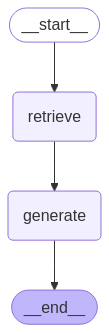

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
print(f'Context: {response["context"]}\n\n')
print(f'Answer: {response["answer"]}')

Context: [Document(id='5880ea7d-d3e4-475e-9070-9c51c2f38644', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='98827596-12aa-4ad3-980d-5efc3297c4b5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibiliti

In [12]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='5880ea7d-d3e4-475e-9070-9c51c2f38644', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='98827596-12aa-4ad3-980d-5efc3297c4b5', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reaso

In [13]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| De|composition| is| the| process| of| breaking| down| a| complex| task| into| smaller|,| manageable| steps| to| facilitate| planning| and| execution|.| It| involves| techniques| like| Chain| of| Thought| (|Co|T|),| where| a| model| is| prompted| to| think| step|-by|-step|,| and| can| also| include| methods| like| Tree| of| Thoughts|,| which| explores| multiple| reasoning| paths| at| each| step|.| This| approach| enhances| performance| on| intricate| tasks| by| clar|ifying| the| reasoning| process| and| allowing| for| structured| execution|.||

In [14]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'section': 'beginning'}

In [15]:
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [16]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [17]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

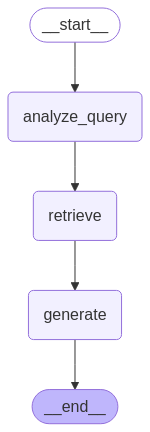

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'end of the post about Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='3f079363-11a1-4206-8edc-b9b80a264826', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'end'}, page_content='"content": "Please now remember the steps:\\n\\nThink step by step and reason yourself to the right decisions to make sure we get it right.\\nFirst lay out the names of the core classes, functions, methods that will be necessary, As well as a quick comment on their purpose.\\n\\nThen you will output the content of each file including ALL code.\\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\\nFILENAME is the lowercase file name including the file extension,\\nLANG is the markup code block language for the code\'s language, and CODE is the code:\\n\\nFILENAME\\n```LANG\\nCODE\\n```\\n\\nPlease note that the code shou